In [21]:
import time
import arviz
import numpy as np
import pandas as pd
import pystan
import scipy.special as sp
import scipy.stats as sts

In [22]:
# Parameters
P = [3, 5, 1, 4]
N = 10 ** 4
SEED = 1729

In [23]:
# Ground truth
np.random.seed(SEED)

true_transmission_rate_mu = np.random.beta(2, 10, len(P))
true_transmission_rate_std = np.sqrt(sts.invgamma.rvs(a=100, size=len(P)))
true_transmission_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_transmission_rate_mu, true_transmission_rate_std)
])

true_occurrence_rate_mu = np.random.beta(2, 10, len(P))
true_occurrence_rate_std = np.sqrt(sts.invgamma.rvs(a=50, size=len(P)))
true_occurrence_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_occurrence_rate_mu, true_occurrence_rate_std)
])

base_rate = np.random.beta(2, 10, 1)

In [24]:
# Simulate data
data = {}
# TODO: Add covariances between same type of activity
for p in range(sum(P)):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)
X = X.loc[:, X.columns.str.startswith('O')]

In [25]:
c = np.array([i + 1 for i, p in enumerate(P) for __ in range(p)])

In [26]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> M;                            // number of places
  int<lower=0> K;                            // number of classes
  int<lower=0> P[K];                         // number of places in each class
  int<lower=0, upper=1> X[N,M];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=1, upper=K> c[M];                // place classes
}
parameters {
  real<lower=0, upper=1> theta[M];           // transmission rates
  real<lower=0, upper=1> mu[K];              // transmission means
  real<lower=0> sigma[K];                    // transmission standard deviations
  real<lower=0, upper=1> rho;                // underlying risk
}
model {
  // Priors
  mu ~ beta(1, 5);
  sigma ~ inv_gamma(10, 1);
  rho ~ uniform(0, 1);
  // Likelihood (classes)
  for (m in 1:M) {
    theta[m] ~ normal(mu[c[m]], sigma[c[m]]);
    target += log(1 / theta[m] + 1 / (1 - theta[m])) -
      (logit(theta[m]) - logit(mu[c[m]]))^2 / (2 * sigma[c[m]]);
  }
  // Likelihood (observations)
  for (n in 1:N) {
    real s = 0.0;
    for (m in 1:M) {
      if (X[n,m] == 1) {
        s += log1m(theta[m]);
      }
    }
    s += log1m(rho);
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_c44bc59eaa2195a5b90a3d2dca57bf86 NOW.


In [27]:
# Set model parameters
nuts_samples = 1000
nuts_burnin = 500
chains = 4

In [28]:
# Fit model
start = time.time()
model_data = {
    'N': N, 'M': sum(P), 'K': len(P), 'P': P,
    'X': X.to_numpy(), 'y': y.to_numpy(), 'c': c}
fit = sm.sampling(
    data=model_data,
    iter=2000,
    warmup=1000,
    chains=8
)
print(f"{time.time() - start:.02f} seconds elapsed")

232.10 seconds elapsed


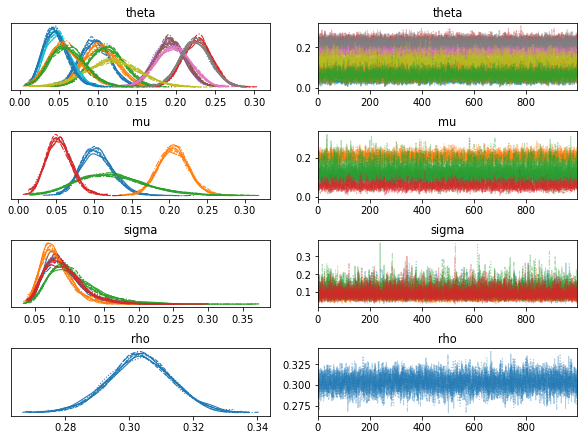

In [29]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [30]:
# View results
print("Inference on original model:")
print(fit)
print('')
print('Ground truth:')
print(true_transmission_rate)
print(true_transmission_rate_mu)
print(true_transmission_rate_std)
print(base_rate)

Inference on original model:
Inference for Stan model: tt_mod_c44bc59eaa2195a5b90a3d2dca57bf86.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]     0.1  2.1e-4   0.02   0.06   0.08    0.1   0.11   0.14   8769    1.0
theta[2]     0.1  2.3e-4   0.02   0.06   0.09    0.1   0.12   0.15   8838    1.0
theta[3]    0.11  2.4e-4   0.02   0.07    0.1   0.11   0.13   0.15   8476    1.0
theta[4]    0.23  1.8e-4   0.02   0.19   0.21   0.23   0.24   0.26  10681    1.0
theta[5]    0.19  1.7e-4   0.02   0.15   0.18   0.19    0.2   0.23  12588    1.0
theta[6]    0.19  1.8e-4   0.02   0.16   0.18   0.19   0.21   0.23  11520    1.0
theta[7]     0.2  1.9e-4   0.02   0.15   0.18    0.2   0.21   0.24  12535    1.0
theta[8]    0.22  1.7e-4   0.02   0.19   0.21   0.22   0.24   0.26  13324    1.0
theta[9]    0.12  4.4e-4   0.03   0.05    0.1   0.12   0.

In [43]:
np.sum((np.mean(fit.extract()['mu'], axis=0) - true_transmission_rate_mu) ** 2)

0.0006387549252677175